In [1]:
#coding:utf-8
import pandas as pd
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False
from ncov.reader import get_data,watch_data
import statsmodels.tsa.api as smt    
from statsmodels.tsa.stattools import adfuller


In [2]:
import torch
from torch.nn.parameter import Parameter
torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
class SEIR_cell(torch.nn.Module):
    def __init__(self, N, beta_init, gamma_2_init, theta_init):
        super(SEIR_cell, self).__init__()
        # self.date_len = date_len
        self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
        self.N = Parameter(torch.tensor([N], requires_grad=True))
        self.gamma_1 = 0.
        self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
        self.alpha = 1.
        self.theta = Parameter(torch.tensor([theta_init], requires_grad=True))
        # self.E_ratio = Parameter(torch.tensor([3.], requires_grad=True))


    def clamp(self, X):
        # return torch.clamp(X, min=0, max=self.N)
        return X

    def forward(self, X):
        S, confirm, Exposed, recover, dead = X
        # self.beta = beta_old + self.beta_add
        # self.gamma_2 = gamma_2_old + self.gamma_2_add
        S_rest = self.clamp(S - self.beta*confirm*S/self.N) # dS/dt
        E = self.clamp(Exposed + self.beta*confirm*S/self.N - self.alpha*Exposed) # dE/dt

        # I = self.clamp(confirm + self.alpha*Exposed - self.gamma_2*confirm - self.theta*confirm) # dI/dt
        # R = self.clamp(recover + self.gamma_2*confirm) # dR/dt
        # D = self.clamp(dead + self.theta*confirm)
        I = self.clamp(confirm + self.alpha*E - self.gamma_2*confirm - self.theta*confirm) # dI/dt
        R = self.clamp(recover + self.gamma_2*I) # dR/dt
        D = self.clamp(dead + self.theta*I)

        return S_rest, I, E, R, D, self.beta, self.gamma_2, self.theta, self.N


In [20]:

class SEIR_model(torch.nn.Module):
    def __init__(self, date_len, pred_date_len=0, N=2870000., beta_init=0.2586,  gamma_2_init=0.018, theta_init=0.001, E_ratio_init=3., I_init=41, R_init=2., D_init=0.):
        super(SEIR_model, self).__init__()
        self.date_len = date_len
        self.SEIR_cells = torch.nn.ModuleList()
        self.SEIR_pred_cells = torch.nn.ModuleList()
        self.N = N
        self.E_ratio = E_ratio_init
        # self.I = (1e-6)*self.N
        # self.E = (self.I * self.E_ratio)
        # self.R = (1e-6 / 2)*self.N
        # self.S = (self.N - self.I - self.E - self.R)
        # self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
        # self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
        self.beta = beta_init
        self.gamma_2 = gamma_2_init
        self.theta = theta_init
        self.I = I_init
        self.E = (self.I * self.E_ratio)
        self.R = R_init
        self.D = D_init
        self.S = (self.N - self.I - self.E - self.R - self.D)
        self.date_len = date_len-1
        self.pred_date_len = pred_date_len
        # self.date_total_len = self.date_len + self.pred_date_len
        for i in range(self.date_len):
            self.SEIR_cells.append(SEIR_cell(self.N,self.beta,self.gamma_2, self.theta))

        self.S_tensor_cur = torch.zeros((self.date_len+1,))
        self.I_tensor_cur = torch.zeros((self.date_len+1,))
        self.E_tensor_cur = torch.zeros((self.date_len+1,))
        self.R_tensor_cur = torch.zeros((self.date_len+1,))
        self.D_tensor_cur = torch.zeros((self.date_len+1,))
        
    
    def forward(self, X):
        inp = self.S, self.I, self.E, self.R, self.D
        # param = beta_init, gamma_2_init
        S_tensor = torch.zeros((self.date_len+1,))
        I_tensor = torch.zeros((self.date_len+1,))
        E_tensor = torch.zeros((self.date_len+1,))
        R_tensor = torch.zeros((self.date_len+1,))
        D_tensor = torch.zeros((self.date_len+1,))
        S_tensor[0], I_tensor[0], E_tensor[0], R_tensor[0], D_tensor[0] = inp
        for i in range(self.date_len):
            S, I, E, R, D, beta_cur, gamma_2_cur, theta_cur, N = self.SEIR_cells[i](inp)
            S_tensor[i+1], I_tensor[i+1], E_tensor[i+1], R_tensor[i+1], D_tensor[i+1] = S, I, E, R, D
            self.beta = beta_cur
            self.gamma_2 = gamma_2_cur
            self.theta = theta_cur
            self.S_cur = S
            self.I_cur = I
            self.E_cur = E
            self.R_cur = R
            self.D_cur = D
            self.N_cur = N
            inp = [S, I, E, R, D]
        self.S_tensor_cur, self.I_tensor_cur, self.E_tensor_cur, self.R_tensor_cur, self.D_tensor_cur = S_tensor, I_tensor, E_tensor, R_tensor, D_tensor
        return S_tensor, I_tensor, E_tensor, R_tensor, D_tensor, beta_cur, gamma_2_cur

    def pred(self, pred_date_len, N_cur=-1, beta=1e7, gamma_2=1e7, theta=1e7):
        if N_cur==-1:
            N_cur=self.N_cur
        if beta==1e7:
            beta=self.beta
        if gamma_2==1e7:
            gamma_2=self.gamma_2
        if theta==1e7:
            theta=self.theta

        cur_pred_cells_len = len(self.SEIR_pred_cells)
        # print("cur_pred_cells_len:", cur_pred_cells_len)
        if cur_pred_cells_len!=pred_date_len:
            self.SEIR_pred_cells = torch.nn.ModuleList()
            for i in range(pred_date_len):
                self.SEIR_pred_cells.append(SEIR_cell(N_cur,beta,gamma_2,theta))
        S_pred_tensor = torch.zeros((pred_date_len,))
        I_pred_tensor = torch.zeros((pred_date_len,))
        E_pred_tensor = torch.zeros((pred_date_len,))
        R_pred_tensor = torch.zeros((pred_date_len,))
        D_pred_tensor = torch.zeros((pred_date_len,))
        # pred:
        inp = self.S_cur, self.I_cur, self.E_cur, self.R_cur, self.D_cur
        for i in range(pred_date_len):
            S, I, E, R, D, beta_, gamma_2_, theta_, N_ = self.SEIR_pred_cells[i](inp)
            S_pred_tensor[i], I_pred_tensor[i], E_pred_tensor[i], R_pred_tensor[i], D_pred_tensor[i] = S, I, E, R, D
            inp = [S, I, E, R, D]
        return S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor
    
    def param_pred(self,beta_list,gamma_2_list,theta_list):
        def test_dif(data):
            data=pd.DataFrame(data)
            dif=0
            p_value = adfuller(data)[1]
            dif_data=data
            while p_value>0.05:
                dif=dif+1
                dif_data=dif_data.diff(1).dropna()
                p_value= adfuller(dif_data)[1]
            return dif
        datas=[beta_list,gamma_2_list,theta_list]
        params=['beta','gamma_2','theta']
        param_dict={}
        for i in range(len(params)):
            param=params[i]
            data=datas[i]
            if i==0:
                if test_dif(data) >2:
                    data=data[np.argmax(data):]
            data_copy=pd.DataFrame(data,columns=[param])
            dif_data=data_copy
            dif_data_list=[data_copy.values]
            dif=0
            p_value = adfuller(data_copy[param])[1]
            while p_value>0.05:
                dif=dif+1
                dif_data=dif_data.diff(1).dropna()
    #             print(dif_data)
                dif_data_list.append(dif_data.values)
                p_value= adfuller(dif_data[param])[1]
            print(u'差分序列次数为：',dif)
    #         print(u'差分序列的白噪声检验结果为：', acorr_ljungbox(dif_data,lags=1))     
            pmax = int(len(data)/10) 
            qmax = int(len(data)/10)
            if dif>1:
                d=0
                data=dif_data
            else:
                d=dif
            bic_matrix = [] #bic矩阵
            for p in range(pmax+1):
                tmp = []
                for q in range(qmax+1):
#                     print(p,q)
                    try: #存在部分报错，所以用try来跳过报错。
                        tmp.append(smt.ARIMA(data, (p,d,q)).fit().bic)
                    except:
                        tmp.append(None)
                bic_matrix.append(tmp)
            bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
            p,q = bic_matrix.stack().astype('float64').idxmin() #先用stack展平，然后用idxmin找出最小值位置。
#             print(u'BIC最小的p值和q值为：%s、%s' %(p,q))
            
            model = smt.ARIMA(data, (p,d,q)).fit() #建立ARIMA(0, 1, 1)模型
            model.summary2() #给出一份模型报告
            param_dict[param]=model.forecast(1)[0][0]
#             print(param_dict[param])
            if dif>1:
                dif_data_list[-1]=np.append(dif_data_list[-1],param_dict[param])
    #             print( dif_data_list[-1])
                for i in range(1,dif+1,1):
                    dif_data_list[-i-1]=np.append(dif_data_list[-i-1],dif_data_list[-i][-1]+ dif_data_list[-i-1][-1])
    #                 print(dif_data_list[-i-1])
                param_dict[param]=dif_data_list[0][-1]
        return param_dict
    
        

In [96]:
#coding:utf-8
def plot_daily_acc(data, accumulated_confirmed, accumulated_pred_confirmed, xlen=10, city=u'武汉', pred_date_len=0):
    T_name = 'time'
    plt.figure(figsize=(xlen, 6))
    time_val = data[T_name].values

    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1, pred_date_len + 1):
        pred_time.append(max_time_val + np.timedelta64(i, 'D'))
    if pred_time == []:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time), axis=0)
    plt.plot(time_val, accumulated_confirmed, color='red', label='累计确诊人数', marker='x')
    plt.plot(merge_time, accumulated_pred_confirmed, color='blue', label='预测的累计确诊人数', marker='x')
    for a, b in zip(merge_time, accumulated_pred_confirmed):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 5), textcoords='offset points', color='blue')
    for a, b in zip(time_val, accumulated_confirmed):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 20), textcoords='offset points', color='red')
    city_title = u'疫情状况-' + city
    plt.title(city_title)
    plt.legend()
    plt.xlabel(u'日期')
    plt.ylabel(u'人数')
    plt.savefig(city+u'累计预测')
    plt.show()
    return
def plot_daily_new(data, new_confirm, pred_new_confirm, xlen=10, city=u'武汉', pred_date_len=0):
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    time_val = time_val[1:]
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D'))
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(time_val, new_confirm, color = 'red', label = '新增确诊人数',marker = 'x')
    plt.plot(merge_time, pred_new_confirm, color = 'blue',label = '新增累计确诊人数',marker = 'x')
    for a,b in zip(merge_time, pred_new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='blue')
    for a,b in zip(time_val, new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='red')
    city_title = u'疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')
    plt.ylabel('人数')
    plt.savefig(city+u'新增预测')
    plt.show()
    return
def cal_acc_confirm(I,R,D):
    return I+R+D
def cal_new_confirm(I,R,D):
    acc_confirm = cal_acc_confirm(I,R,D)
    new_confirm = np.zeros((len(acc_confirm)-1))
    for i in range(len(acc_confirm)-1):
        new_confirm[i] = acc_confirm[i+1]-acc_confirm[i]
    return new_confirm
def get_data_acc_confirm(data,c='confirmed'):
    return np.array(data[c])


import torch.optim as optim
import os


def make_dir(city, date):
    save_root_path = 'models/'
    model_city_path = os.path.join(save_root_path, city)

    model_city_date_path = os.path.join(model_city_path, date)

    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path


def train(data, model_city_date_path, N=1e7, I_init=1e-6, R_init=1e-6 / 2., D_init=1e-6 / 6.,
          features=['accumulated_confirmed', 'accumulated_recovered', 'accumulated_death'], max_epoches=400):
    model_pt = os.path.join(model_city_date_path, 'model.pt')
    data_feat = data[features]
    Input = np.array(data_feat, dtype=np.float)
    print(Input.shape)
    date_len = len(Input)
    print(date_len)
    model = SEIR_model(date_len, pred_date_len=10, N=N, I_init=I_init, R_init=R_init, D_init=D_init)

    lr = 0.01
    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5

    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
    loss_min = 1e8
    for step in range(max_epoches):
        print("Training step: ", step)
        Input = torch.tensor(Input)
        model_inp = Input[:-1]
        S, I, E, R, D, beta, gamma_2 = model(model_inp.float())
        # print(output)
        loss_fn = torch.nn.MSELoss()
        pred_confirmed = I
        pred_recovered = R
        pred_dead = D
        # print(pred_confirmed)

        confirmed_gt_tensor = Input[:, 0]
        recovered_gt_tensor = Input[:, 1]
        dead_gt_tensor = Input[:, 2]
        # print(recovered_gt_tensor)
        # print(pred_confirmed.shape)
        # loss = loss_fn(pred_confirmed,confirmed_gt_tensor)
        loss = loss_fn(pred_confirmed, confirmed_gt_tensor) + loss_fn(pred_recovered, recovered_gt_tensor) + loss_fn(
            pred_dead, dead_gt_tensor)
        print("Loss: {}".format(loss))
        if loss < loss_min:
            loss_min = loss
            torch.save(model, model_pt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Loss_min:", loss_min)
    return S, I, E, R, D
def load_model_predict(model_city_date_path, data, N_cur=-1,beta=1e7,gamma_2=1e7,theta=1e7, city_name='深圳',c='confirmed', features=['I','cured','dead'], pred_date_len=5):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    confirm_origin = get_data_acc_confirm(data,c=c)
    print(confirm_origin)
#     plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name)
    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

    beta = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
    gamma_2 = []
    for i in range(len(model.SEIR_cells)):
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
    theta = []
    for i in range(len(model.SEIR_cells)):
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
    if city_name=='深圳':
        theta=get_recent_curve(theta)
    print(len(theta))
    param = model.param_pred(beta,gamma_2,theta)

    print(param)
    S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(beta=param['beta'],gamma_2=param['gamma_2'],theta=param['theta'], pred_date_len = pred_date_len)
    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)

    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total
    plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)
def read_data(path):
    data = pd.read_csv(path)
    data['I'] = data['confirmed']-data['dead']-data['cured']
    if 'nation' in path:    #全国有个E
        data['E']=data['suspected']+data['close_contact']+data['under_medical_observation']
    data['time']= pd.to_datetime(data['time'])
    return data
def train_with_city_data(data, N, date, cityname='深圳',max_epoches=2000):
    city_pinyin = {'深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    features=['I', 'cured','dead']
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    N = N
    #train里面会保存模型
    S,I,E,R,D = train(data, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=max_epoches)
    return model_city_date_path
#read data



(15, 3)
15
Training step:  0
Loss: 14933.243517727318
Training step:  1
Loss: 5765.4618840347875
Training step:  2
Loss: 5757.817207723621
Training step:  3
Loss: 6019.973681905188
Training step:  4
Loss: 5443.304327550675
Training step:  5
Loss: 4708.770600577024
Training step:  6
Loss: 4333.876125140409
Training step:  7
Loss: 4143.34768297394
Training step:  8
Loss: 3864.521298208378
Training step:  9
Loss: 3587.69783784463
Training step:  10
Loss: 3361.115383745678
Training step:  11
Loss: 3139.6730191619336
Training step:  12
Loss: 2923.4880141890953
Training step:  13
Loss: 2723.520314327383
Training step:  14
Loss: 2534.029236329779
Training step:  15
Loss: 2353.93449395042
Training step:  16
Loss: 2184.9203400346223
Training step:  17
Loss: 2026.078274745615
Training step:  18
Loss: 1877.3053914969419
Training step:  19
Loss: 1738.6800414881275
Training step:  20
Loss: 1609.8818230341026
Training step:  21
Loss: 1490.721333975655
Training step:  22
Loss: 1380.9156654547132
Trai

Training step:  191
Loss: 16.733125823715053
Training step:  192
Loss: 16.58459206219989
Training step:  193
Loss: 16.43793422531712
Training step:  194
Loss: 16.29312278855084
Training step:  195
Loss: 16.150129022753763
Training step:  196
Loss: 16.008924952701108
Training step:  197
Loss: 15.86948331834003
Training step:  198
Loss: 15.73177753856297
Training step:  199
Loss: 15.595781677341897
Training step:  200
Loss: 15.461470412069945
Training step:  201
Loss: 15.328819003968244
Training step:  202
Loss: 15.19780327042152
Training step:  203
Loss: 15.068399559116743
Training step:  204
Loss: 14.940584723865072
Training step:  205
Loss: 14.814336101996386
Training step:  206
Loss: 14.689631493220876
Training step:  207
Loss: 14.566449139859676
Training step:  208
Loss: 14.444767708353131
Training step:  209
Loss: 14.32456627196003
Training step:  210
Loss: 14.205824294566764
Training step:  211
Loss: 14.08852161553217
Training step:  212
Loss: 13.972638435495575
Training step:  21

Training step:  377
Loss: 6.774082171689013
Training step:  378
Loss: 6.75233809810255
Training step:  379
Loss: 6.730713551426276
Training step:  380
Loss: 6.709207522912934
Training step:  381
Loss: 6.687819017087669
Training step:  382
Loss: 6.666547051286732
Training step:  383
Loss: 6.645390655226962
Training step:  384
Loss: 6.624348870603181
Training step:  385
Loss: 6.603420750712556
Training step:  386
Loss: 6.582605360102614
Training step:  387
Loss: 6.561901774241959
Training step:  388
Loss: 6.541309079211384
Training step:  389
Loss: 6.5208263714141435
Training step:  390
Loss: 6.500452757303851
Training step:  391
Loss: 6.480187353128766
Training step:  392
Loss: 6.460029284690716
Training step:  393
Loss: 6.439977687118536
Training step:  394
Loss: 6.420031704653915
Training step:  395
Loss: 6.400190490449309
Training step:  396
Loss: 6.380453206377023
Training step:  397
Loss: 6.3608190228482755
Training step:  398
Loss: 6.341287118641967
Training step:  399
Loss: 6.321

Training step:  565
Loss: 4.055555455813359
Training step:  566
Loss: 4.045792856103912
Training step:  567
Loss: 4.036061381963858
Training step:  568
Loss: 4.026360851261684
Training step:  569
Loss: 4.016691083462613
Training step:  570
Loss: 4.0070518996145275
Training step:  571
Loss: 3.997443122333145
Training step:  572
Loss: 3.987864575788451
Training step:  573
Loss: 3.9783160856897495
Training step:  574
Loss: 3.9687974792729364
Training step:  575
Loss: 3.95930858528484
Training step:  576
Loss: 3.949849233971892
Training step:  577
Loss: 3.9404192570632013
Training step:  578
Loss: 3.931018487761523
Training step:  579
Loss: 3.9216467607236125
Training step:  580
Loss: 3.912303912055545
Training step:  581
Loss: 3.9029897792874984
Training step:  582
Loss: 3.8937042013776266
Training step:  583
Loss: 3.8844470186752185
Training step:  584
Loss: 3.8752180729420127
Training step:  585
Loss: 3.8660172072916508
Training step:  586
Loss: 3.8568442662469447
Training step:  587
Lo

Training step:  754
Loss: 124.63943275649363
Training step:  755
Loss: 103.95768159500973
Training step:  756
Loss: 124.55489538559277
Training step:  757
Loss: 103.88614274552339
Training step:  758
Loss: 124.4596813128296
Training step:  759
Loss: 103.80907933887187
Training step:  760
Loss: 124.36006015486652
Training step:  761
Loss: 103.73092286634412
Training step:  762
Loss: 124.26148186516404
Training step:  763
Loss: 103.65542541143282
Training step:  764
Loss: 124.16843945012566
Training step:  765
Loss: 103.58558563140488
Training step:  766
Loss: 124.08440581728841
Training step:  767
Loss: 103.52362647782546
Training step:  768
Loss: 124.01183385225711
Training step:  769
Loss: 103.47101601447798
Training step:  770
Loss: 123.95220768973667
Training step:  771
Loss: 103.4285222124363
Training step:  772
Loss: 123.9061330063688
Training step:  773
Loss: 103.39629274634714
Training step:  774
Loss: 123.87345471966059
Training step:  775
Loss: 103.37395138730716
Training step

Loss: 123.75605259247756
Training step:  945
Loss: 103.10384847544881
Training step:  946
Loss: 123.75316515277714
Training step:  947
Loss: 103.0998339771609
Training step:  948
Loss: 123.75028767908707
Training step:  949
Loss: 103.0958348830669
Training step:  950
Loss: 123.74742081999945
Training step:  951
Loss: 103.09185155054925
Training step:  952
Loss: 123.74456499851944
Training step:  953
Loss: 103.08788417337566
Training step:  954
Loss: 123.74172043024805
Training step:  955
Loss: 103.08393279798811
Training step:  956
Loss: 123.7388871474938
Training step:  957
Loss: 103.07999734340412
Training step:  958
Loss: 123.73606502727304
Training step:  959
Loss: 103.07607762338998
Training step:  960
Loss: 123.73325382139467
Training step:  961
Loss: 103.07217336942689
Training step:  962
Loss: 123.73045318682746
Training step:  963
Loss: 103.0682842533559
Training step:  964
Loss: 123.7276627150165
Training step:  965
Loss: 103.06440990879643
Training step:  966
Loss: 123.72488

Training step:  1134
Loss: 123.51582693379146
Training step:  1135
Loss: 102.77704510026432
Training step:  1136
Loss: 123.51360186987618
Training step:  1137
Loss: 102.77409837384474
Training step:  1138
Loss: 123.51138243605557
Training step:  1139
Loss: 102.77116056275919
Training step:  1140
Loss: 123.5091686147038
Training step:  1141
Loss: 102.76823163167649
Training step:  1142
Loss: 123.50696038825627
Training step:  1143
Loss: 102.76531154542776
Training step:  1144
Loss: 123.50475773921674
Training step:  1145
Loss: 102.76240026905262
Training step:  1146
Loss: 123.50256065016181
Training step:  1147
Loss: 102.75949776774695
Training step:  1148
Loss: 123.50036910371497
Training step:  1149
Loss: 102.75660400691459
Training step:  1150
Loss: 123.49818308261081
Training step:  1151
Loss: 102.7537189521418
Training step:  1152
Loss: 123.4960025696271
Training step:  1153
Loss: 102.75084256917908
Training step:  1154
Loss: 123.49382754760096
Training step:  1155
Loss: 102.747974

Training step:  1321
Loss: 102.53705558648426
Training step:  1322
Loss: 123.32913495924848
Training step:  1323
Loss: 102.53480846788108
Training step:  1324
Loss: 123.32737143445486
Training step:  1325
Loss: 102.53256765647932
Training step:  1326
Loss: 123.32561217441794
Training step:  1327
Loss: 102.5303331302149
Training step:  1328
Loss: 123.3238571671991
Training step:  1329
Loss: 102.52810486712353
Training step:  1330
Loss: 123.32210640085911
Training step:  1331
Loss: 102.52588284532806
Training step:  1332
Loss: 123.32035986352489
Training step:  1333
Loss: 102.52366704305864
Training step:  1334
Loss: 123.31861754334575
Training step:  1335
Loss: 102.52145743863497
Training step:  1336
Loss: 123.3168794285096
Training step:  1337
Loss: 102.51925401046748
Training step:  1338
Loss: 123.31514550725421
Training step:  1339
Loss: 102.51705673709137
Training step:  1340
Loss: 123.31341576788435
Training step:  1341
Loss: 102.51486559713577
Training step:  1342
Loss: 123.311690

Training step:  1501
Loss: 102.35771451374208
Training step:  1502
Loss: 123.1861911747777
Training step:  1503
Loss: 102.35595705404235
Training step:  1504
Loss: 123.1847679985995
Training step:  1505
Loss: 102.35420425529604
Training step:  1506
Loss: 123.18334815630305
Training step:  1507
Loss: 102.35245610244976
Training step:  1508
Loss: 123.18193163897615
Training step:  1509
Loss: 102.35071258053559
Training step:  1510
Loss: 123.18051843775056
Training step:  1511
Loss: 102.34897367463869
Training step:  1512
Loss: 123.179108543776
Training step:  1513
Loss: 102.34723936991017
Training step:  1514
Loss: 123.1777019482389
Training step:  1515
Loss: 102.34550965154754
Training step:  1516
Loss: 123.1762986423189
Training step:  1517
Loss: 102.34378450480308
Training step:  1518
Loss: 123.1748986172643
Training step:  1519
Loss: 102.34206391501218
Training step:  1520
Loss: 123.17350186431722
Training step:  1521
Loss: 102.34034786752316
Training step:  1522
Loss: 123.1721083747

Loss: 123.0670166844224
Training step:  1689
Loss: 102.21103815180987
Training step:  1690
Loss: 123.06586870585791
Training step:  1691
Loss: 102.2096602937687
Training step:  1692
Loss: 123.06472333707487
Training step:  1693
Loss: 102.20828590949
Training step:  1694
Loss: 123.06358057130697
Training step:  1695
Loss: 102.20691498845234
Training step:  1696
Loss: 123.0624404018028
Training step:  1697
Loss: 102.20554752018288
Training step:  1698
Loss: 123.06130282184873
Training step:  1699
Loss: 102.20418349424317
Training step:  1700
Loss: 123.06016782473667
Training step:  1701
Loss: 102.20282290023529
Training step:  1702
Loss: 123.05903540378358
Training step:  1703
Loss: 102.20146572778886
Training step:  1704
Loss: 123.05790555231957
Training step:  1705
Loss: 102.20011196658956
Training step:  1706
Loss: 123.05677826370957
Training step:  1707
Loss: 102.1987616063465
Training step:  1708
Loss: 123.05565353132229
Training step:  1709
Loss: 102.19741463680573
Training step:  

Training step:  1875
Loss: 102.09649686768931
Training step:  1876
Loss: 122.96966352964493
Training step:  1877
Loss: 102.09540158609438
Training step:  1878
Loss: 122.96873373495423
Training step:  1879
Loss: 102.09430894398064
Training step:  1880
Loss: 122.96780599148131
Training step:  1881
Loss: 102.09321893375794
Training step:  1882
Loss: 122.96688029403222
Training step:  1883
Loss: 102.09213154787045
Training step:  1884
Loss: 122.96595663745059
Training step:  1885
Loss: 102.09104677876894
Training step:  1886
Loss: 122.96503501655377
Training step:  1887
Loss: 102.08996461893838
Training step:  1888
Loss: 122.96411542621483
Training step:  1889
Loss: 102.08888506090622
Training step:  1890
Loss: 122.96319786131983
Training step:  1891
Loss: 102.0878080972053
Training step:  1892
Loss: 122.96228231674033
Training step:  1893
Loss: 102.08673372040124
Training step:  1894
Loss: 122.9613687873955
Training step:  1895
Loss: 102.08566192308948
Training step:  1896
Loss: 122.96045

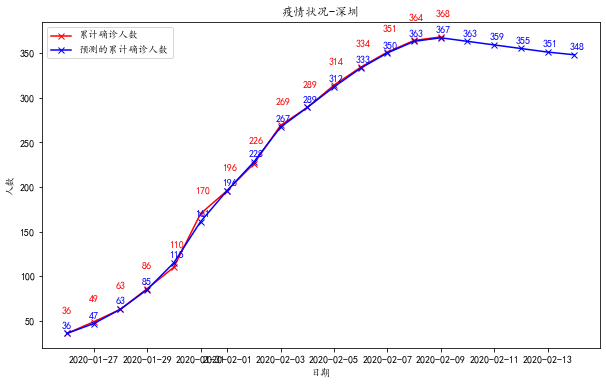

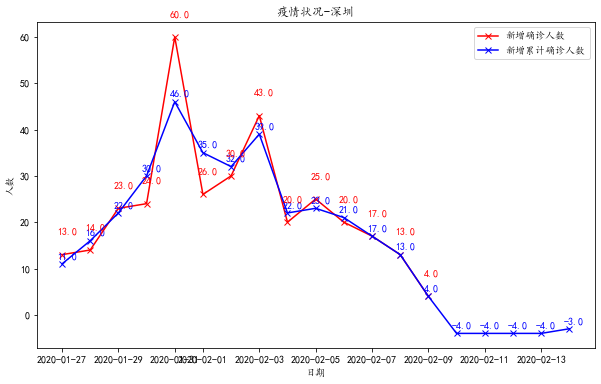

In [97]:
citys=['湖北','武汉','深圳','全国']
N_inits=[59170000.,2870000.,13026600.]
datetime='02-10'
time='0209'
paths=['./ncov/data/hubei_截至'+time+'_24时.csv','./ncov/data/wuhan_截至'+time+'_24时.csv','./ncov/data/shenzhen_截至'+time+'_24时.csv','./ncov/data/nation_截至'+time+'_24时.csv']
for i in range(4):
#     i=2
    data=read_data(paths[i])
    city_name=citys[i]
    N=0
    if i == 3:
        N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
    else :
        N = N_inits[i]
    model_city_date_path = train_with_city_data(data,N,datetime,city_name)
    load_model_predict(model_city_date_path, data, city_name=city_name)

In [6]:
def plot_daily_acc(data, accumulated_confirmed, accumulated_pred_confirmed, xlen=10, city=u'武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    T_name = 'time'
    plt.figure(figsize=(xlen, 6))
    # accumulated_confirmed = data[I_name]
    # accumulated_death = data['accumulated_death']
    # accumulated_recovered = data[R_name]
    time_val = data[T_name].values
    
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(time_val, accumulated_confirmed, color = 'red', label = '累计确诊人数',marker = 'x')
    plt.plot(merge_time, accumulated_pred_confirmed, color = 'blue',label = '预测的累计确诊人数',marker = 'x')
    # plt.plot(accumulated_death, color = 'gray',label = '累计死亡人数',marker = 'x')
    # plt.plot(time_val, accumulated_recovered, color = 'green', label = '累计治愈人数',marker = '.')
    # plt.plot(merge_time, pred_R, color = 'black', label = '预测的累计治愈人数',marker = '.')
    # plt.plot(RES[:,2],color = 'orange',label = 'The Exposed',marker = '.')
    # plt.plot(RES[:,3],color = 'green',label = 'The Recovered',marker = '.')
    # for a, b in zip(merge_time, pred_I):
    #     plt.text(a, b+0.3, b, ha='center', va='bottom', fontsize=12, color='blue')
    # for a, b in zip(time_val, accumulated_confirmed):
    #     plt.text(a, b-10, b, ha='center', va='bottom', fontsize=12, color='red')
    for a,b in zip(merge_time, accumulated_pred_confirmed):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='blue')
    for a,b in zip(time_val, accumulated_confirmed):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='red')

    city_title = u'疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel(u'日期')   
    plt.ylabel(u'人数')
    plt.show()

In [7]:
def plot_daily_new(data, new_confirm, pred_new_confirm, xlen=10, city=u'武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    time_val = time_val[1:]
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(time_val, new_confirm, color = 'red', label = '新增确诊人数',marker = 'x')
    plt.plot(merge_time, pred_new_confirm, color = 'blue',label = '新增累计确诊人数',marker = 'x')
    # plt.plot(accumulated_death, color = 'gray',label = '累计死亡人数',marker = 'x')
    # plt.plot(time_val, accumulated_recovered, color = 'green', label = '累计治愈人数',marker = '.')
    # plt.plot(merge_time, pred_R, color = 'black', label = '预测的累计治愈人数',marker = '.')
    # plt.plot(RES[:,2],color = 'orange',label = 'The Exposed',marker = '.')
    # plt.plot(RES[:,3],color = 'green',label = 'The Recovered',marker = '.')
    # for a, b in zip(merge_time, pred_I):
    #     plt.text(a, b+0.3, b, ha='center', va='bottom', fontsize=12, color='blue')
    # for a, b in zip(time_val, accumulated_confirmed):
    #     plt.text(a, b-10, b, ha='center', va='bottom', fontsize=12, color='red')
    for a,b in zip(merge_time, pred_new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='blue')
    for a,b in zip(time_val, new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='red')

    city_title = u'疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel(u'日期')   
    plt.ylabel(u'人数')
    plt.show()

In [8]:
import torch.optim as optim
import os
# def loss_fn(pred, gt):
#     T = gt.shape
#     loss = torch.tensor([0.])
#     for i in range(T.data.numpy()):
#         loss = loss + torch.mean((i+1)*torch.pow(pred[i]-gt[i],2))
    # return loss
def make_dir(city, date):
    save_root_path = 'models/'
    model_city_path = os.path.join(save_root_path,city)
    
    model_city_date_path = os.path.join(model_city_path,date)

    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path

def train(data, model_city_date_path, N=1e7, I_init=1e-6, R_init=1e-6/2., D_init=1e-6/6., features=['accumulated_confirmed', 'accumulated_recovered', 'accumulated_death'], max_epoches = 400):
    model_pt = os.path.join(model_city_date_path,'model.pt')
    data_feat = data[features]
    Input = np.array(data_feat,dtype=np.float)
    print(Input.shape)
    date_len = len(Input)
    print(date_len)
    model = SEIR_model(date_len,  pred_date_len = 10, N=N, I_init=I_init, R_init=R_init, D_init=D_init)

    lr = 0.01
    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5

    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
    loss_min = 1e8
    for step in range(max_epoches):
        print("Training step: ", step)
        Input = torch.tensor(Input)
        model_inp = Input[:-1]
        S,I,E,R,D, beta,gamma_2 = model(model_inp.float())
        # print(output)
        loss_fn = torch.nn.MSELoss()
        pred_confirmed = I
        pred_recovered = R
        pred_dead = D
        # print(pred_confirmed)
        
        confirmed_gt_tensor = Input[:,0]
        recovered_gt_tensor = Input[:,1]
        dead_gt_tensor = Input[:,2]
        # print(recovered_gt_tensor)
        # print(pred_confirmed.shape)
        # loss = loss_fn(pred_confirmed,confirmed_gt_tensor)
        loss = loss_fn(pred_confirmed, confirmed_gt_tensor) + loss_fn(pred_recovered, recovered_gt_tensor) + loss_fn(pred_dead, dead_gt_tensor)
        print("Loss: {}".format(loss))
        if loss<loss_min:
            loss_min = loss
            torch.save(model, model_pt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Loss_min:",loss_min)
    return S,I,E,R,D


# model_city_date_path = make_dir('wuhan','02-03')
# features=['accumulated_confirmed', 'accumulated_recovered']
# S,I,E,R,model = train(data_wh_feat, model_city_date_path, N=2870000., I_init=41, R_init=2., features=features, max_epoches=400)

In [9]:
def load_model_predict(model_city_date_path, data, N_cur=0,beta=0,gamma_2=0,theta=0, city_name='深圳',c='confirmed', features=['I','cured','dead'], pred_date_len=5):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    confirm_origin = get_data_acc_confirm(data,c=c)
    print(confirm_origin)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name)


    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

    S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(N_cur=N_cur,beta=beta,gamma_2=gamma_2,theta=theta, pred_date_len = pred_date_len)
    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)

    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total

    plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)

In [87]:
# # data_china = pd.read_excel('./ncov/data/nation_data.xlsx')
# data_china = pd.read_csv('./ncov/data/nation/nation.csv')
# data_china

In [88]:
# data_china['time'] = data_china['time'].apply(lambda x: '2020/'+x.replace('月','/').replace('日',''))
# data_china['time'] = pd.to_datetime(data_china['time'])

In [89]:
# data_china['accumulated_confirmed']

In [90]:
# model_city_date_path = make_dir('china','02-08')
# features=['accumulated_confirmed', 'accumulated_cured', 'accumulated_death']
# I_init = float(data_china['accumulated_confirmed'].iloc[0])
# R_init = float(data_china['accumulated_cured'].iloc[0])
# D_init = float(data_china['accumulated_death'].iloc[0])
# N = 13000000000.
# S_china,I_china,E_china,R_china,D_china = train(data_china, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)

In [91]:
# model_city_date_path='models/china/02-08'

In [92]:
# param = {'beta_model_3': 0.09111736783585582, 'gamma_2_model_3': 0.016532860820465893, 'N_model_3': 13000000000.106674, 'theta_model_3': 0.006605514213817316}
# def change_key(param,i):
#     for k in list(param.keys()):
#         old_key = k
#         new_key = k.replace(f'_model_{i}','')
#         param[new_key]=param.pop(old_key)
#     return param
# param = change_key(param,3)
# param

In [93]:
# load_model_predict(model_city_date_path, data_china, N_cur=param['N'],beta=param['beta'],gamma_2=param['gamma_2'],theta=param['theta'],city_name='全国', c='accumulated_confirmed', features=features)

In [94]:
# merge_data = pd.read_csv('./ncov/data/nation/allcity_20200209.csv')
# merge_data = merge_data.rename(columns = {'updatetime':'time'})
# merge_data['time'] = merge_data['time'].apply(lambda x: '2020/'+x)
# merge_data['time']

In [95]:
# merge_data['I'] = merge_data['confirmed']-merge_data['dead']-merge_data['cured']
# merge_data['I']

In [96]:
# merge_data['time']= pd.to_datetime(merge_data['time'])
# merge_data['time']

In [52]:
def read_data(path):
    data = pd.read_csv(path)
    data['I'] = data['confirmed']-data['dead']-data['cured']
    # data['E']=data['suspected']+data['close_contact']+data['under_medical_observation']
    data['time']= pd.to_datetime(data['time'])
    # data['time'] = data['time'].apply(lambda x:x-np.timedelta64(1,'D'))
    return data

In [53]:
data_sz = read_data('./ncov/data/shenzhen_截至0209_24时.csv')
# data_sz['I'] = data_sz['confirmed']-data_sz['dead']-data_sz['cured']
# data_sz['time']= pd.to_datetime(data_sz['time'])
data_sz

,confirmed,suspected,dead,cured,close_contact,time,I
0,36,0,0,2,0,2020-01-26,34
1,49,0,0,3,0,2020-01-27,46
2,63,0,0,4,0,2020-01-28,59
3,86,0,0,4,291,2020-01-29,82
4,110,0,0,4,325,2020-01-30,106
5,170,0,0,4,327,2020-01-31,166
6,196,0,0,5,569,2020-02-01,191
7,226,0,0,5,662,2020-02-02,221
8,269,0,0,10,904,2020-02-03,259
9,289,0,0,13,878,2020-02-04,276


In [56]:
def cal_acc_confirm(I,R,D):
    return I+R+D
def cal_new_confirm(I,R,D):
    acc_confirm = cal_acc_confirm(I,R,D)
    new_confirm = np.zeros((len(acc_confirm)-1))
    for i in range(len(acc_confirm)-1):
        new_confirm[i] = acc_confirm[i+1]-acc_confirm[i]
    return new_confirm
def get_data_acc_confirm(data,c='confirmed'):
    return np.array(data[c])

In [57]:
model_city_date_path = make_dir('shenzhen','02-10')
features=['I', 'cured','dead']
I_init = float(data_sz['I'].iloc[0])
R_init = float(data_sz['cured'].iloc[0])
D_init = float(data_sz['dead'].iloc[0])
N = 13026600.
S,I,E,R,D = train(data_sz, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)

(15, 3)
15
Training step:  0
Loss: 14933.243517727318
Training step:  1
Loss: 5765.4618840347875
Training step:  2
Loss: 5757.817207723621
Training step:  3
Loss: 6019.973681905188
Training step:  4
Loss: 5443.304327550675
Training step:  5
Loss: 4708.770600577024
Training step:  6
Loss: 4333.876125140409
Training step:  7
Loss: 4143.34768297394
Training step:  8
Loss: 3864.521298208378
Training step:  9
Loss: 3587.69783784463
Training step:  10
Loss: 3361.115383745678
Training step:  11
Loss: 3139.6730191619336
Training step:  12
Loss: 2923.4880141890953
Training step:  13
Loss: 2723.520314327383
Training step:  14
Loss: 2534.029236329779
Training step:  15
Loss: 2353.93449395042
Training step:  16
Loss: 2184.9203400346223
Training step:  17
Loss: 2026.078274745615
Training step:  18
Loss: 1877.3053914969419
Training step:  19
Loss: 1738.6800414881275
Training step:  20
Loss: 1609.8818230341026
Training step:  21
Loss: 1490.721333975655
Training step:  22
Loss: 1380.9156654547132
Trai

Loss: 16.883565874073586
Training step:  191
Loss: 16.733125823715053
Training step:  192
Loss: 16.58459206219989
Training step:  193
Loss: 16.43793422531712
Training step:  194
Loss: 16.29312278855084
Training step:  195
Loss: 16.150129022753763
Training step:  196
Loss: 16.008924952701108
Training step:  197
Loss: 15.86948331834003
Training step:  198
Loss: 15.73177753856297
Training step:  199
Loss: 15.595781677341897
Training step:  200
Loss: 15.461470412069945
Training step:  201
Loss: 15.328819003968244
Training step:  202
Loss: 15.19780327042152
Training step:  203
Loss: 15.068399559116743
Training step:  204
Loss: 14.940584723865072
Training step:  205
Loss: 14.814336101996386
Training step:  206
Loss: 14.689631493220876
Training step:  207
Loss: 14.566449139859676
Training step:  208
Loss: 14.444767708353131
Training step:  209
Loss: 14.32456627196003
Training step:  210
Loss: 14.205824294566764
Training step:  211
Loss: 14.08852161553217
Training step:  212
Loss: 13.972638435

Training step:  378
Loss: 6.75233809810255
Training step:  379
Loss: 6.730713551426276
Training step:  380
Loss: 6.709207522912934
Training step:  381
Loss: 6.687819017087669
Training step:  382
Loss: 6.666547051286732
Training step:  383
Loss: 6.645390655226962
Training step:  384
Loss: 6.624348870603181
Training step:  385
Loss: 6.603420750712556
Training step:  386
Loss: 6.582605360102614
Training step:  387
Loss: 6.561901774241959
Training step:  388
Loss: 6.541309079211384
Training step:  389
Loss: 6.5208263714141435
Training step:  390
Loss: 6.500452757303851
Training step:  391
Loss: 6.480187353128766
Training step:  392
Loss: 6.460029284690716
Training step:  393
Loss: 6.439977687118536
Training step:  394
Loss: 6.420031704653915
Training step:  395
Loss: 6.400190490449309
Training step:  396
Loss: 6.380453206377023
Training step:  397
Loss: 6.3608190228482755
Training step:  398
Loss: 6.341287118641967
Training step:  399
Loss: 6.321856680742092
Training step:  400
Loss: 6.302

Loss: 4.036061381963858
Training step:  568
Loss: 4.026360851261684
Training step:  569
Loss: 4.016691083462613
Training step:  570
Loss: 4.0070518996145275
Training step:  571
Loss: 3.997443122333145
Training step:  572
Loss: 3.987864575788451
Training step:  573
Loss: 3.9783160856897495
Training step:  574
Loss: 3.9687974792729364
Training step:  575
Loss: 3.95930858528484
Training step:  576
Loss: 3.949849233971892
Training step:  577
Loss: 3.9404192570632013
Training step:  578
Loss: 3.931018487761523
Training step:  579
Loss: 3.9216467607236125
Training step:  580
Loss: 3.912303912055545
Training step:  581
Loss: 3.9029897792874984
Training step:  582
Loss: 3.8937042013776266
Training step:  583
Loss: 3.8844470186752185
Training step:  584
Loss: 3.8752180729420127
Training step:  585
Loss: 3.8660172072916508
Training step:  586
Loss: 3.8568442662469447
Training step:  587
Loss: 3.8476990956310337
Training step:  588
Loss: 3.8385815427018843
Training step:  589
Loss: 3.829491455946

Training step:  756
Loss: 124.55489538559277
Training step:  757
Loss: 103.88614274552339
Training step:  758
Loss: 124.4596813128296
Training step:  759
Loss: 103.80907933887187
Training step:  760
Loss: 124.36006015486652
Training step:  761
Loss: 103.73092286634412
Training step:  762
Loss: 124.26148186516404
Training step:  763
Loss: 103.65542541143282
Training step:  764
Loss: 124.16843945012566
Training step:  765
Loss: 103.58558563140488
Training step:  766
Loss: 124.08440581728841
Training step:  767
Loss: 103.52362647782546
Training step:  768
Loss: 124.01183385225711
Training step:  769
Loss: 103.47101601447798
Training step:  770
Loss: 123.95220768973667
Training step:  771
Loss: 103.4285222124363
Training step:  772
Loss: 123.9061330063688
Training step:  773
Loss: 103.39629274634714
Training step:  774
Loss: 123.87345471966059
Training step:  775
Loss: 103.37395138730716
Training step:  776
Loss: 123.85339148018649
Training step:  777
Loss: 103.36070342769995
Training step

Training step:  943
Loss: 103.10787784597171
Training step:  944
Loss: 123.75605259247756
Training step:  945
Loss: 103.10384847544881
Training step:  946
Loss: 123.75316515277714
Training step:  947
Loss: 103.0998339771609
Training step:  948
Loss: 123.75028767908707
Training step:  949
Loss: 103.0958348830669
Training step:  950
Loss: 123.74742081999945
Training step:  951
Loss: 103.09185155054925
Training step:  952
Loss: 123.74456499851944
Training step:  953
Loss: 103.08788417337566
Training step:  954
Loss: 123.74172043024805
Training step:  955
Loss: 103.08393279798811
Training step:  956
Loss: 123.7388871474938
Training step:  957
Loss: 103.07999734340412
Training step:  958
Loss: 123.73606502727304
Training step:  959
Loss: 103.07607762338998
Training step:  960
Loss: 123.73325382139467
Training step:  961
Loss: 103.07217336942689
Training step:  962
Loss: 123.73045318682746
Training step:  963
Loss: 103.0682842533559
Training step:  964
Loss: 123.7276627150165
Training step: 

Training step:  1127
Loss: 102.7889218731973
Training step:  1128
Loss: 123.5225360838215
Training step:  1129
Loss: 102.78593912800775
Training step:  1130
Loss: 123.52029402294079
Training step:  1131
Loss: 102.78296544151446
Training step:  1132
Loss: 123.51805764555544
Training step:  1133
Loss: 102.78000077757356
Training step:  1134
Loss: 123.51582693379146
Training step:  1135
Loss: 102.77704510026432
Training step:  1136
Loss: 123.51360186987618
Training step:  1137
Loss: 102.77409837384474
Training step:  1138
Loss: 123.51138243605557
Training step:  1139
Loss: 102.77116056275919
Training step:  1140
Loss: 123.5091686147038
Training step:  1141
Loss: 102.76823163167649
Training step:  1142
Loss: 123.50696038825627
Training step:  1143
Loss: 102.76531154542776
Training step:  1144
Loss: 123.50475773921674
Training step:  1145
Loss: 102.76240026905262
Training step:  1146
Loss: 123.50256065016181
Training step:  1147
Loss: 102.75949776774695
Training step:  1148
Loss: 123.500369

Training step:  1308
Loss: 123.3416000606564
Training step:  1309
Loss: 102.550671998392
Training step:  1310
Loss: 123.33980634377515
Training step:  1311
Loss: 102.54838656730163
Training step:  1312
Loss: 123.33801697663662
Training step:  1313
Loss: 102.5461075779964
Training step:  1314
Loss: 123.3362319469734
Training step:  1315
Loss: 102.54383500779997
Training step:  1316
Loss: 123.33445124257226
Training step:  1317
Loss: 102.54156883411729
Training step:  1318
Loss: 123.33267485122796
Training step:  1319
Loss: 102.53930903447
Training step:  1320
Loss: 123.33090276082112
Training step:  1321
Loss: 102.53705558648426
Training step:  1322
Loss: 123.32913495924848
Training step:  1323
Loss: 102.53480846788108
Training step:  1324
Loss: 123.32737143445486
Training step:  1325
Loss: 102.53256765647932
Training step:  1326
Loss: 123.32561217441794
Training step:  1327
Loss: 102.5303331302149
Training step:  1328
Loss: 123.3238571671991
Training step:  1329
Loss: 102.5281048671235

Training step:  1491
Loss: 102.36657225718585
Training step:  1492
Loss: 123.19335737792274
Training step:  1493
Loss: 102.36479126500598
Training step:  1494
Loss: 123.1919173976513
Training step:  1495
Loss: 102.36301500988769
Training step:  1496
Loss: 123.1904807962333
Training step:  1497
Loss: 102.36124347647724
Training step:  1498
Loss: 123.1890475646151
Training step:  1499
Loss: 102.35947664950115
Training step:  1500
Loss: 123.18761769379417
Training step:  1501
Loss: 102.35771451374208
Training step:  1502
Loss: 123.1861911747777
Training step:  1503
Loss: 102.35595705404235
Training step:  1504
Loss: 123.1847679985995
Training step:  1505
Loss: 102.35420425529604
Training step:  1506
Loss: 123.18334815630305
Training step:  1507
Loss: 102.35245610244976
Training step:  1508
Loss: 123.18193163897615
Training step:  1509
Loss: 102.35071258053559
Training step:  1510
Loss: 123.18051843775056
Training step:  1511
Loss: 102.34897367463869
Training step:  1512
Loss: 123.17910854

Training step:  1679
Loss: 102.21797991907673
Training step:  1680
Loss: 123.07163483231443
Training step:  1681
Loss: 102.21658453317654
Training step:  1682
Loss: 123.07047634664914
Training step:  1683
Loss: 102.21519267419706
Training step:  1684
Loss: 123.06932049800464
Training step:  1685
Loss: 102.21380433141329
Training step:  1686
Loss: 123.06816727953411
Training step:  1687
Loss: 102.21241949416368
Training step:  1688
Loss: 123.0670166844224
Training step:  1689
Loss: 102.21103815180987
Training step:  1690
Loss: 123.06586870585791
Training step:  1691
Loss: 102.2096602937687
Training step:  1692
Loss: 123.06472333707487
Training step:  1693
Loss: 102.20828590949
Training step:  1694
Loss: 123.06358057130697
Training step:  1695
Loss: 102.20691498845234
Training step:  1696
Loss: 123.0624404018028
Training step:  1697
Loss: 102.20554752018288
Training step:  1698
Loss: 123.06130282184873
Training step:  1699
Loss: 102.20418349424317
Training step:  1700
Loss: 123.060167824

Loss: 122.97528566536805
Training step:  1865
Loss: 102.10201313529518
Training step:  1866
Loss: 122.97434345372201
Training step:  1867
Loss: 102.10090454155556
Training step:  1868
Loss: 122.97340332469948
Training step:  1869
Loss: 102.0997986256289
Training step:  1870
Loss: 122.9724652730289
Training step:  1871
Loss: 102.0986953798035
Training step:  1872
Loss: 122.97152929346207
Training step:  1873
Loss: 102.09759479637832
Training step:  1874
Loss: 122.97059538073896
Training step:  1875
Loss: 102.09649686768931
Training step:  1876
Loss: 122.96966352964493
Training step:  1877
Loss: 102.09540158609438
Training step:  1878
Loss: 122.96873373495423
Training step:  1879
Loss: 102.09430894398064
Training step:  1880
Loss: 122.96780599148131
Training step:  1881
Loss: 102.09321893375794
Training step:  1882
Loss: 122.96688029403222
Training step:  1883
Loss: 102.09213154787045
Training step:  1884
Loss: 122.96595663745059
Training step:  1885
Loss: 102.09104677876894
Training ste

In [58]:
def load_model_predict(model_city_date_path, data, N_cur=-1,beta=1e7,gamma_2=1e7,theta=1e7, city_name='深圳',c='confirmed', features=['I','cured','dead'], pred_date_len=5):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    confirm_origin = get_data_acc_confirm(data,c=c)
    print(confirm_origin)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name)


    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)
    beta = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
    gamma_2 = []
    for i in range(len(model.SEIR_cells)):
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
    theta = []
    for i in range(len(model.SEIR_cells)):
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
    param = model.param_pred(beta,gamma_2,theta)
    print(param)
    S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(beta=param['beta'],gamma_2=param['gamma_2'],theta=param['theta'], pred_date_len = pred_date_len)
    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)

    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total

    plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)

In [59]:
model_city_date_path = 'models/shenzhen/02-10'

[ 36  49  63  86 110 170 196 226 269 289 314 334 351 364 368]


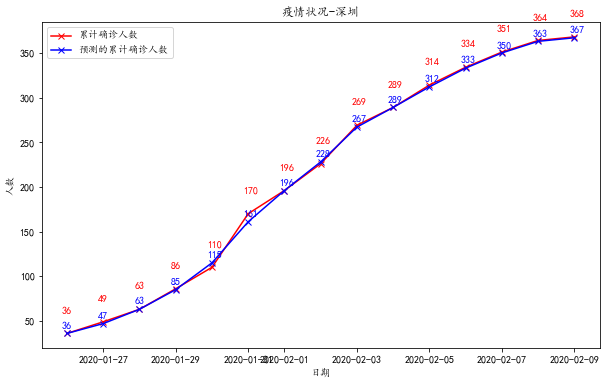

{'beta': -0.011667957698391032, 'gamma_2': 0.02185521739434857, 'theta': 0.0012506750246709815}


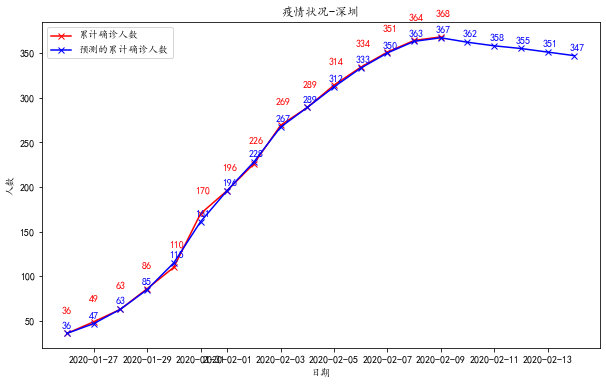

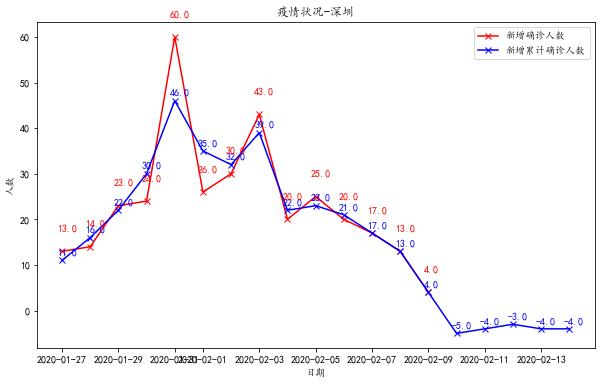

In [60]:
load_model_predict(model_city_date_path, data_sz, city_name='深圳')

In [24]:
data_wh = read_data('./ncov/data/wuhan_截至0209_24时.csv')
data_wh

,confirmed,suspected,dead,cured,time,I
0,258,0,6,25,2020-01-20,227
1,363,0,9,28,2020-01-21,326
2,425,0,17,28,2020-01-22,380
3,495,0,23,31,2020-01-23,441
4,572,0,38,32,2020-01-24,502
5,618,0,45,40,2020-01-25,533
6,698,0,63,42,2020-01-26,593
7,1590,0,85,45,2020-01-27,1460
8,1905,0,104,78,2020-01-28,1723
9,2261,0,129,85,2020-01-29,2047


In [25]:
model_city_date_path = make_dir('wuhan','02-09')
features=['I', 'cured','dead']
I_init = float(data_wh['I'].iloc[0])
R_init = float(data_wh['cured'].iloc[0])
D_init = float(data_wh['dead'].iloc[0])
N = 2870000.
S,I,E,R,D = train(data_wh, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=2000)

models/wuhan\02-09
(21, 3)
21
Training step:  0
Loss: 1075744.3220813368
Training step:  1
Loss: 5600076.553611361
Training step:  2
Loss: 812536.7321220154
Training step:  3
Loss: 2105007.2196322363
Training step:  4
Loss: 1081961.9312569764
Training step: 

C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SEIR_model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SEIR_cell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


 5
Loss: 393231.3027475004
Training step:  6
Loss: 652136.6463882716
Training step:  7
Loss: 331509.4730027067
Training step:  8
Loss: 369693.2141843825
Training step:  9
Loss: 302937.5816170784
Training step:  10
Loss: 282633.8885012685
Training step:  11
Loss: 262321.5250830837
Training step:  12
Loss: 245222.79773570335
Training step:  13
Loss: 231359.28645861117
Training step:  14
Loss: 218236.89402041634
Training step:  15
Loss: 206217.39417449833
Training step:  16
Loss: 195216.85058802782
Training step:  17
Loss: 184559.75568020996
Training step:  18
Loss: 174811.77948031138
Training step:  19
Loss: 165427.40289190284
Training step:  20
Loss: 156715.1703875006
Training step:  21
Loss: 148467.4715854879
Training step:  22
Loss: 140733.88324505714
Training step:  23
Loss: 133474.13637594317
Training step:  24
Loss: 126656.07552166059
Training step:  25
Loss: 120265.1744470463
Training step:  26
Loss: 114271.58218457669
Training step:  27
Loss: 108652.84991879636
Training step:  28

Training step:  192
Loss: 269869.6848178018
Training step:  193
Loss: 207794.85261776857
Training step:  194
Loss: 269851.0858345969
Training step:  195
Loss: 207762.4572582953
Training step:  196
Loss: 269823.7011564033
Training step:  197
Loss: 207724.56547398123
Training step:  198
Loss: 269787.84360532067
Training step:  199
Loss: 207681.94116254526
Training step:  200
Loss: 269745.2808657637
Training step:  201
Loss: 207636.00321897856
Training step:  202
Loss: 269698.41199073364
Training step:  203
Loss: 207588.34474815754
Training step:  204
Loss: 269649.62618346454
Training step:  205
Loss: 207540.39368659572
Training step:  206
Loss: 269600.89326247235
Training step:  207
Loss: 207493.22432039815
Training step:  208
Loss: 269553.5746965384
Training step:  209
Loss: 207447.4982305352
Training step:  210
Loss: 269508.40817181586
Training step:  211
Loss: 207403.49776900627
Training step:  212
Loss: 269465.6048638573
Training step:  213
Loss: 207361.2122933467
Training step:  214

Loss: 205079.21158719994
Training step:  378
Loss: 267243.6002760233
Training step:  379
Loss: 205059.0408103447
Training step:  380
Loss: 267224.3703124546
Training step:  381
Loss: 205038.98834070106
Training step:  382
Loss: 267205.2545571598
Training step:  383
Loss: 205019.0528573349
Training step:  384
Loss: 267186.2517222185
Training step:  385
Loss: 204999.2330645067
Training step:  386
Loss: 267167.3605441074
Training step:  387
Loss: 204979.52769085654
Training step:  388
Loss: 267148.57978295325
Training step:  389
Loss: 204959.93548881813
Training step:  390
Loss: 267129.90822207596
Training step:  391
Loss: 204940.45523399292
Training step:  392
Loss: 267111.3446672931
Training step:  393
Loss: 204921.085724412
Training step:  394
Loss: 267092.8879461876
Training step:  395
Loss: 204901.82577992024
Training step:  396
Loss: 267074.5369075457
Training step:  397
Loss: 204882.67424158854
Training step:  398
Loss: 267056.2904208129
Training step:  399
Loss: 204863.62997112292

Training step:  565
Loss: 203574.26641736514
Training step:  566
Loss: 265812.2576628419
Training step:  567
Loss: 203561.49514761922
Training step:  568
Loss: 265800.1334790497
Training step:  569
Loss: 203548.77609657627
Training step:  570
Loss: 265788.05908040254
Training step:  571
Loss: 203536.10889298687
Training step:  572
Loss: 265776.03410675126
Training step:  573
Loss: 203523.4931692599
Training step:  574
Loss: 265764.0582015942
Training step:  575
Loss: 203510.92856153921
Training step:  576
Loss: 265752.1310121527
Training step:  577
Loss: 203498.41470960673
Training step:  578
Loss: 265740.25218914676
Training step:  579
Loss: 203485.95125676083
Training step:  580
Loss: 265728.42138678476
Training step:  581
Loss: 203473.53784987636
Training step:  582
Loss: 265716.63826282194
Training step:  583
Loss: 203461.1741392939
Training step:  584
Loss: 265704.9024783949
Training step:  585
Loss: 203448.8597788143
Training step:  586
Loss: 265693.21369808255
Training step:  58

Training step:  756
Loss: 264842.3020001342
Training step:  757
Loss: 202543.24312415693
Training step:  758
Loss: 264833.6874234544
Training step:  759
Loss: 202534.19809634337
Training step:  760
Loss: 264825.0999227934
Training step:  761
Loss: 202525.18156003277
Training step:  762
Loss: 264816.53934493946
Training step:  763
Loss: 202516.19335620393
Training step:  764
Loss: 264808.00553816085
Training step:  765
Loss: 202507.23332707034
Training step:  766
Loss: 264799.4983517747
Training step:  767
Loss: 202498.30131606394
Training step:  768
Loss: 264791.0176363644
Training step:  769
Loss: 202489.39716784365
Training step:  770
Loss: 264782.56324367196
Training step:  771
Loss: 202480.52072828994
Training step:  772
Loss: 264774.1350266757
Training step:  773
Loss: 202471.67184448658
Training step:  774
Loss: 264765.7328394556
Training step:  775
Loss: 202462.85036465438
Training step:  776
Loss: 264757.35653720645
Training step:  777
Loss: 202454.05613822213
Training step:  7

Loss: 264126.92709985183
Training step:  947
Loss: 201792.53589600633
Training step:  948
Loss: 264120.3390625014
Training step:  949
Loss: 201785.62810489515
Training step:  950
Loss: 264113.76771091623
Training step:  951
Loss: 201778.7379399373
Training step:  952
Loss: 264107.2129690841
Training step:  953
Loss: 201771.86532108803
Training step:  954
Loss: 264100.67476152856
Training step:  955
Loss: 201765.0101687831
Training step:  956
Loss: 264094.1530132096
Training step:  957
Loss: 201758.17240396712
Training step:  958
Loss: 264087.6476495863
Training step:  959
Loss: 201751.35194813053
Training step:  960
Loss: 264081.1585966877
Training step:  961
Loss: 201744.54872330095
Training step:  962
Loss: 264074.6857810127
Training step:  963
Loss: 201737.76265197803
Training step:  964
Loss: 264068.22912948695
Training step:  965
Loss: 201730.9936571549
Training step:  966
Loss: 264061.7885695432
Training step:  967
Loss: 201724.24166233718
Training step:  968
Loss: 264055.3640290

Training step:  1131
Loss: 201222.03066145815
Training step:  1132
Loss: 263577.04722639907
Training step:  1133
Loss: 201216.46505306353
Training step:  1134
Loss: 263571.74111900595
Training step:  1135
Loss: 201210.91146017256
Training step:  1136
Loss: 263566.4463489599
Training step:  1137
Loss: 201205.36983714995
Training step:  1138
Loss: 263561.16287355276
Training step:  1139
Loss: 201199.8401386251
Training step:  1140
Loss: 263555.8906502614
Training step:  1141
Loss: 201194.32231943638
Training step:  1142
Loss: 263550.6296368058
Training step:  1143
Loss: 201188.81633474593
Training step:  1144
Loss: 263545.3797912146
Training step:  1145
Loss: 201183.32213990533
Training step:  1146
Loss: 263540.1410716329
Training step:  1147
Loss: 201177.83969052194
Training step:  1148
Loss: 263534.91343652457
Training step:  1149
Loss: 201172.36894247966
Training step:  1150
Loss: 263529.6968445871
Training step:  1151
Loss: 201166.90985191052
Training step:  1152
Loss: 263524.4912547

Training step:  1319
Loss: 200745.95525643625
Training step:  1320
Loss: 263122.74889569567
Training step:  1321
Loss: 200741.3490002182
Training step:  1322
Loss: 263118.34933669923
Training step:  1323
Loss: 200736.75137942762
Training step:  1324
Loss: 263113.9579534883
Training step:  1325
Loss: 200732.16236613132
Training step:  1326
Loss: 263109.574719984
Training step:  1327
Loss: 200727.58193248336
Training step:  1328
Loss: 263105.1996101167
Training step:  1329
Loss: 200723.0100507418
Training step:  1330
Loss: 263100.8325979508
Training step:  1331
Loss: 200718.44669329323
Training step:  1332
Loss: 263096.4736576538
Training step:  1333
Loss: 200713.89183266432
Training step:  1334
Loss: 263092.12276359415
Training step:  1335
Loss: 200709.34544156742
Training step:  1336
Loss: 263087.7798902454
Training step:  1337
Loss: 200704.80749276842
Training step:  1338
Loss: 263083.44501213974
Training step:  1339
Loss: 200700.27795922218
Training step:  1340
Loss: 263079.118104037

Loss: 262745.49964144285
Training step:  1507
Loss: 200347.32770406
Training step:  1508
Loss: 262741.76271287014
Training step:  1509
Loss: 200343.42652037047
Training step:  1510
Loss: 262738.0319742595
Training step:  1511
Loss: 200339.5318296979
Training step:  1512
Loss: 262734.30740831274
Training step:  1513
Loss: 200335.64361363178
Training step:  1514
Loss: 262730.588997809
Training step:  1515
Loss: 200331.76185387783
Training step:  1516
Loss: 262726.87672565476
Training step:  1517
Loss: 200327.8865322044
Training step:  1518
Loss: 262723.1705747568
Training step:  1519
Loss: 200324.01763040345
Training step:  1520
Loss: 262719.47052805393
Training step:  1521
Loss: 200320.1551304054
Training step:  1522
Loss: 262715.7765686986
Training step:  1523
Loss: 200316.29901421518
Training step:  1524
Loss: 262712.0886798112
Training step:  1525
Loss: 200312.4492638524
Training step:  1526
Loss: 262708.4068445222
Training step:  1527
Loss: 200308.60586144112
Training step:  1528
Lo

Training step:  1690
Loss: 262425.6238779446
Training step:  1691
Loss: 200013.4824768781
Training step:  1692
Loss: 262422.392021532
Training step:  1693
Loss: 200010.1101619036
Training step:  1694
Loss: 262419.1650197422
Training step:  1695
Loss: 200006.74292047686
Training step:  1696
Loss: 262415.9428604355
Training step:  1697
Loss: 200003.38073973806
Training step:  1698
Loss: 262412.72553154425
Training step:  1699
Loss: 200000.0236068916
Training step:  1700
Loss: 262409.51302106754
Training step:  1701
Loss: 199996.6715091903
Training step:  1702
Loss: 262406.305317035
Training step:  1703
Loss: 199993.32443392632
Training step:  1704
Loss: 262403.102407501
Training step:  1705
Loss: 199989.98236841185
Training step:  1706
Loss: 262399.9042805414
Training step:  1707
Loss: 199986.64530002646
Training step:  1708
Loss: 262396.71092432237
Training step:  1709
Loss: 199983.3132162311
Training step:  1710
Loss: 262393.5223271026
Training step:  1711
Loss: 199979.98610449609
Trai

Loss: 199725.9329342257
Training step:  1874
Loss: 262147.20715028123
Training step:  1875
Loss: 199722.97485491476
Training step:  1876
Loss: 262144.37621334643
Training step:  1877
Loss: 199720.02084789585
Training step:  1878
Loss: 262141.54917730976
Training step:  1879
Loss: 199717.07090383442
Training step:  1880
Loss: 262138.72603341992
Training step:  1881
Loss: 199714.12501339798
Training step:  1882
Loss: 262135.90677281326
Training step:  1883
Loss: 199711.18316725537
Training step:  1884
Loss: 262133.09138672065
Training step:  1885
Loss: 199708.24535614907
Training step:  1886
Loss: 262130.2798664351
Training step:  1887
Loss: 199705.3115708509
Training step:  1888
Loss: 262127.47220324446
Training step:  1889
Loss: 199702.381802129
Training step:  1890
Loss: 262124.6683884309
Training step:  1891
Loss: 199699.45604081283
Training step:  1892
Loss: 262121.86841338032
Training step:  1893
Loss: 199696.5342777483
Training step:  1894
Loss: 262119.07226944246
Training step:  

In [26]:
model_city_date_path='models/wuhan/02-09'

[  258   363   425   495   572   618   698  1590  1905  2261  2639  3215
  4109  5142  6384  8351 10117 11618 13603 14982 16902]


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30123 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24773 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 29366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20917 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 27494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matp

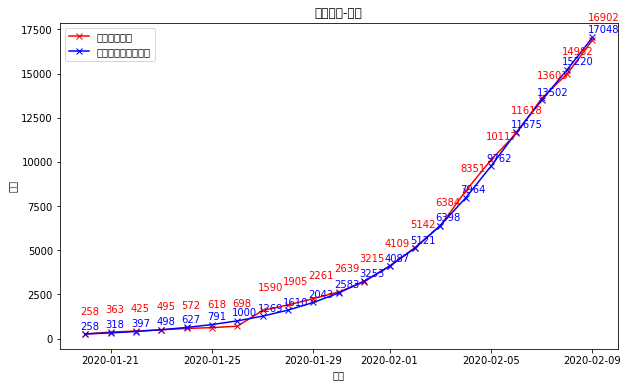

差分序列次数为： 1
0 0
0 1
1 0
1 1
BIC最小的p值和q值为：0、1
0.1346784452062565
差分序列次数为： 1
0 0
0 1
0 2
1 0
1 1
1 2


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2 0
2 1
2 2


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


BIC最小的p值和q值为：0、1
0.014087746624891973
差分序列次数为： 1
0 0
0 1
0 2
1 0
1 1


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1 2
2 0
2 1
2 2
BIC最小的p值和q值为：0、0
0.003586248758575628
{'beta': 0.1346784452062565, 'gamma_2': 0.014087746624891973, 'theta': 0.003586248758575628}


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30123 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24773 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 29366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20917 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 27494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matp

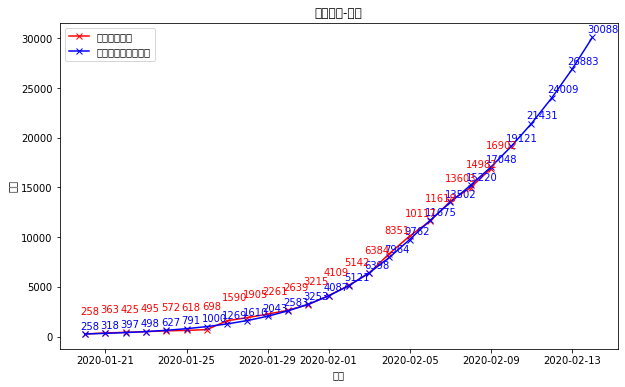

C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30123 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24773 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 29366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20917 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 27494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matp

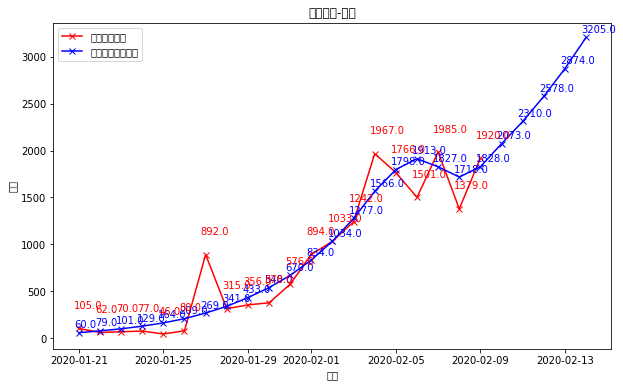

In [28]:
load_model_predict(model_city_date_path, data_wh, N_cur=param['N_model_1'],beta=param['beta_model_1'],gamma_2=param['gamma_2_model_1'],theta=param['theta_model_1'], city_name='武汉')

In [110]:
# param = {'beta_model_2': 0.03808052845960208, 'gamma_2_model_2': 0.011726751251695009, 'N_model_2': 59170000.21805534, 'theta_model_2': 0.003805129170338665}
# i=2
# for k in list(param.keys()):
#     old_key = k
#     new_key = k.replace(f'_model_{i}','')
#     param[new_key]=param.pop(old_key)
# param

In [36]:
def train_with_city_data(data, N, date, cityname='深圳',max_epoches=2000):
    city_pinyin = {'深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    features=['I', 'cured','dead']
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    N = N
    S,I,E,R,D = train(data, model_city_date_path, N=N, I_init=I_init, R_init=R_init, D_init=D_init, features=features, max_epoches=max_epoches)
    return model_city_date_path

In [112]:
data_hubei = read_data('./ncov/data/hubei_截至0209_24时i.csv')
data_hubei

,confirmed,suspected,dead,cured,close_contact,under_medical_observation,quit_medical_observation,time,I
0,270,0,6,25,1070,331,739,2020-01-20,239
1,375,0,9,28,1181,426,755,2020-01-21,338
2,444,0,17,28,2556,1693,863,2020-01-22,399
3,549,0,24,31,3653,2776,877,2020-01-23,494
4,729,0,39,32,5682,4711,971,2020-01-24,658
5,1052,0,52,42,7989,6904,1085,2020-01-25,958
6,1423,0,76,44,10394,9103,1291,2020-01-26,1303
7,2714,0,100,47,16904,15559,1345,2020-01-27,2567
8,3554,0,125,80,22095,20366,1729,2020-01-28,3349
9,4586,0,162,90,28780,26632,2148,2020-01-29,4334


In [113]:
# param = {'beta_model_2': 0.03808052845960208, 'gamma_2_model_2': 0.011726751251695009, 'N_model_2': 0, 'theta_model_2': 0.003805129170338665}

In [114]:
model_city_date_path = train_with_city_data(data_hubei,59170000.,'02-08','湖北')

555
Loss: 872839.330382037
Training step:  1556
Loss: 669415.1439158998
Training step:  1557
Loss: 872823.1480143704
Training step:  1558
Loss: 669398.6483449434
Training step:  1559
Loss: 872806.9988472472
Training step:  1560
Loss: 669382.186563009
Training step:  1561
Loss: 872790.8827756529
Training step:  1562
Loss: 669365.7584629584
Training step:  1563
Loss: 872774.7996951195
Training step:  1564
Loss: 669349.3639379631
Training step:  1565
Loss: 872758.7495012515
Training step:  1566
Loss: 669333.0028816931
Training step:  1567
Loss: 872742.7320904778
Training step:  1568
Loss: 669316.6751884097
Training step:  1569
Loss: 872726.7473596112
Training step:  1570
Loss: 669300.3807527468
Training step:  1571
Loss: 872710.7952058689
Training step:  1572
Loss: 669284.1194699481
Training step:  1573
Loss: 872694.8755271897
Training step:  1574
Loss: 669267.8912355811
Training step:  1575
Loss: 872678.9882214658
Training step:  1576
Loss: 669251.6959455821
Training step:  1577
Loss: 87

[  270   375   444   549   729  1052  1423  2714  3554  4586  5806  7153
  9074 11177 13522 16678 19665 22112 24953 27100 29631]


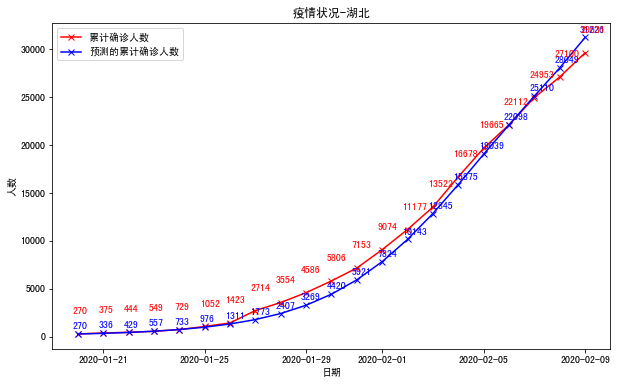

差分序列次数为： 0
0 0
0 1
0 2
1 0
/home/todd/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
1 1
1 2
2 0
/home/todd/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
2 1
2 2
BIC最小的p值和q值为：2、0
/home/todd/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/todd/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/todd/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning

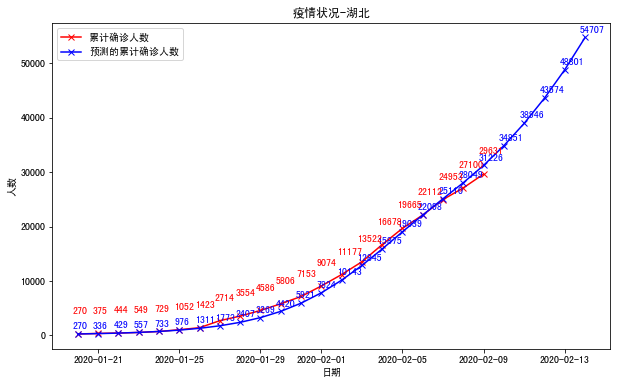

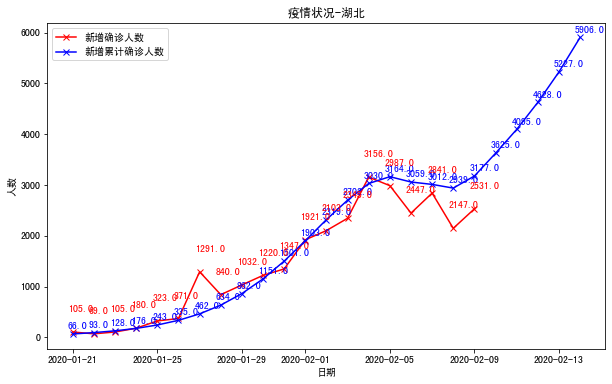

In [115]:
load_model_predict(model_city_date_path, data_hubei, city_name='湖北')

In [34]:
data_china = read_data('./ncov/dta/nation_截至0209_24时.csv')
data_china

,confirmed,new_confirmed,suspected,new_suspected,dead,new_death,cured,new_cured,close_contact,under_medical_observation,quit_medical_observation,time,I,E
0,291,77,54,27,6,6,0,0,1739,922,817,2020-01-20,285,2715
1,440,149,136,82,9,3,0,0,2197,1349,848,2020-01-21,431,3682
2,571,131,393,257,17,8,0,0,5897,4928,969,2020-01-22,554,11218
3,830,259,1072,680,25,8,34,6,9507,8420,1087,2020-01-23,771,18999
4,1287,444,1965,1118,41,16,38,3,15197,13967,1230,2020-01-24,1208,31129
5,1975,688,2684,1309,56,15,49,11,23431,21556,1875,2020-01-25,1870,47671
6,2744,769,5794,3806,80,24,51,2,32799,30453,2346,2020-01-26,2613,69046
7,4515,1771,6973,2077,106,26,60,9,47833,44132,3701,2020-01-27,4349,98938
8,5974,1459,9239,3248,132,26,103,43,65537,59990,5547,2020-01-28,5739,134766
9,7711,1737,12167,4148,170,38,124,21,88693,81947,6746,2020-01-29,7417,182807


In [31]:
def read_data(path):
    data = pd.read_csv(path)
    data['I'] = data['confirmed']-data['dead']-data['cured']
    data['E']=data['suspected']+data['close_contact']+data['under_medical_observation']
    data['time']= pd.to_datetime(data['time'])
    # data['time'] = data['time'].apply(lambda x:x-np.timedelta64(1,'D'))
    return data

In [37]:
N_init = (max(data_china['E'])+max(data_china['I'])+max(data_china['cured'])+max(data_china['dead']))*100.
model_city_date_path = train_with_city_data(data_china,N_init,'02-10','全国')

models/china\02-10
(21, 3)
21
Training step:  0
Loss: 110729725.99577776
Training step:  1
Loss: 54522034.84472122
Training step:  2
Loss: 39381296.1485002
Training step: 

C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SEIR_model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SEIR_cell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


 3
Loss: 36580289.82006091
Training step:  4
Loss: 26768522.037949234
Training step:  5
Loss: 24139021.75185706
Training step:  6
Loss: 18757562.26283764
Training step:  7
Loss: 16296538.76527815
Training step:  8
Loss: 13412598.078488618
Training step:  9
Loss: 11763489.50084396
Training step:  10
Loss: 10310742.144076122
Training step:  11
Loss: 9381921.750488834
Training step:  12
Loss: 8600506.811358485
Training step:  13
Loss: 7999175.002693756
Training step:  14
Loss: 7468680.567313196
Training step:  15
Loss: 6981774.101316891
Training step:  16
Loss: 6529917.377634196
Training step:  17
Loss: 6100431.243330378
Training step:  18
Loss: 5696530.19287293
Training step:  19
Loss: 5317899.44332194
Training step:  20
Loss: 4963591.18391772
Training step:  21
Loss: 4633245.10070584
Training step:  22
Loss: 4325660.411684379
Training step:  23
Loss: 4039413.6407327084
Training step:  24
Loss: 3773224.4983895435
Training step:  25
Loss: 3525847.793638177
Training step:  26
Loss: 3296057

Training step:  194
Loss: 215078.63347244676
Training step:  195
Loss: 214010.81157970673
Training step:  196
Loss: 212951.47801909567
Training step:  197
Loss: 211900.53127176728
Training step:  198
Loss: 210857.8716386594
Training step:  199
Loss: 209823.40118968973
Training step:  200
Loss: 208797.0237150433
Training step:  201
Loss: 207778.6446784445
Training step:  202
Loss: 206768.1711723176
Training step:  203
Loss: 205765.5118747358
Training step:  204
Loss: 204770.57700806303
Training step:  205
Loss: 203783.2782992213
Training step:  206
Loss: 202803.52894147421
Training step:  207
Loss: 201831.243557686
Training step:  208
Loss: 200866.3381649399
Training step:  209
Loss: 199908.73014049983
Training step:  210
Loss: 198958.33818898659
Training step:  211
Loss: 198015.08231079395
Training step:  212
Loss: 197078.88377156103
Training step:  213
Loss: 196149.66507282978
Training step:  214
Loss: 195227.34992356715
Training step:  215
Loss: 194311.86321290713
Training step:  216

Training step:  380
Loss: 1356559.096896625
Training step:  381
Loss: 1736600.6479007562
Training step:  382
Loss: 1356022.7543571529
Training step:  383
Loss: 1736072.9076325886
Training step:  384
Loss: 1355491.988320225
Training step:  385
Loss: 1735550.9798300336
Training step:  386
Loss: 1354966.7305877113
Training step:  387
Loss: 1735034.7475118833
Training step:  388
Loss: 1354446.8502752115
Training step:  389
Loss: 1734524.021401861
Training step:  390
Loss: 1353932.1833384775
Training step:  391
Loss: 1734018.5788467266
Training step:  392
Loss: 1353422.5545662162
Training step:  393
Loss: 1733518.191696571
Training step:  394
Loss: 1352917.792606146
Training step:  395
Loss: 1733022.6444359592
Training step:  396
Loss: 1352417.7391046192
Training step:  397
Loss: 1732531.744382245
Training step:  398
Loss: 1351922.253245502
Training step:  399
Loss: 1732045.3259067566
Training step:  400
Loss: 1351431.2129635743
Training step:  401
Loss: 1731563.2505099915
Training step:  4

Training step:  567
Loss: 1702198.160628404
Training step:  568
Loss: 1321332.0795872977
Training step:  569
Loss: 1701937.3304028553
Training step:  570
Loss: 1321069.4752110045
Training step:  571
Loss: 1701678.1165989889
Training step:  572
Loss: 1320808.506639985
Training step:  573
Loss: 1701420.5041056152
Training step:  574
Loss: 1320549.1585074896
Training step:  575
Loss: 1701164.4780044649
Training step:  576
Loss: 1320291.4156432992
Training step:  577
Loss: 1700910.0235669045
Training step:  578
Loss: 1320035.2630708427
Training step:  579
Loss: 1700657.1262514163
Training step:  580
Loss: 1319780.6860038831
Training step:  581
Loss: 1700405.7716998223
Training step:  582
Loss: 1319527.6698431747
Training step:  583
Loss: 1700155.9457346727
Training step:  584
Loss: 1319276.200173937
Training step:  585
Loss: 1699907.6343564068
Training step:  586
Loss: 1319026.2627622571
Training step:  587
Loss: 1699660.8237400504
Training step:  588
Loss: 1318777.8435525675
Training step

Training step:  751
Loss: 1683488.3461760695
Training step:  752
Loss: 1302516.2943053618
Training step:  753
Loss: 1683330.6483825445
Training step:  754
Loss: 1302357.8830531498
Training step:  755
Loss: 1683173.7106735122
Training step:  756
Loss: 1302200.2382179308
Training step:  757
Loss: 1683017.5275848028
Training step:  758
Loss: 1302043.3542663525
Training step:  759
Loss: 1682862.0937041675
Training step:  760
Loss: 1301887.2257183017
Training step:  761
Loss: 1682707.403671462
Training step:  762
Loss: 1301731.847146547
Training step:  763
Loss: 1682553.4521779092
Training step:  764
Loss: 1301577.2131756733
Training step:  765
Loss: 1682400.2339646132
Training step:  766
Loss: 1301423.3184814588
Training step:  767
Loss: 1682247.7438228815
Training step:  768
Loss: 1301270.157790515
Training step:  769
Loss: 1682095.9765931575
Training step:  770
Loss: 1301117.7258795209
Training step:  771
Loss: 1681944.9271647064
Training step:  772
Loss: 1300966.0175747192
Training step

Training step:  938
Loss: 1290472.6184487154
Training step:  939
Loss: 1671385.7807523045
Training step:  940
Loss: 1290367.230963895
Training step:  941
Loss: 1671281.1416331802
Training step:  942
Loss: 1290262.26048908
Training step:  943
Loss: 1671176.9146025365
Training step:  944
Loss: 1290157.7045627711
Training step:  945
Loss: 1671073.0972409055
Training step:  946
Loss: 1290053.5607428262
Training step:  947
Loss: 1670969.687147961
Training step:  948
Loss: 1289949.8266064192
Training step:  949
Loss: 1670866.681942462
Training step:  950
Loss: 1289846.4997498004
Training step:  951
Loss: 1670764.0792613865
Training step:  952
Loss: 1289743.57778757
Training step:  953
Loss: 1670661.876759774
Training step:  954
Loss: 1289641.058353114
Training step:  955
Loss: 1670560.0721111726
Training step:  956
Loss: 1289538.9390980797
Training step:  957
Loss: 1670458.6630067236
Training step:  958
Loss: 1289437.2176923747
Training step:  959
Loss: 1670357.6471557233
Training step:  960

Training step:  1123
Loss: 1663225.2513271335
Training step:  1124
Loss: 1282184.1966177002
Training step:  1125
Loss: 1663150.345221552
Training step:  1126
Loss: 1282109.113444768
Training step:  1127
Loss: 1663075.6894955127
Training step:  1128
Loss: 1282034.281736109
Training step:  1129
Loss: 1663001.28290493
Training step:  1130
Loss: 1281959.700238573
Training step:  1131
Loss: 1662927.1242142466
Training step:  1132
Loss: 1281885.367707308
Training step:  1133
Loss: 1662853.2121958022
Training step:  1134
Loss: 1281811.2829057502
Training step:  1135
Loss: 1662779.5456304688
Training step:  1136
Loss: 1281737.4446056439
Training step:  1137
Loss: 1662706.1233067533
Training step:  1138
Loss: 1281663.8515865607
Training step:  1139
Loss: 1662632.9440211102
Training step:  1140
Loss: 1281590.502636394
Training step:  1141
Loss: 1662560.0065783665
Training step:  1142
Loss: 1281517.3965511855
Training step:  1143
Loss: 1662487.3097910958
Training step:  1144
Loss: 1281444.5321348

Training step:  1309
Loss: 1657189.7316925584
Training step:  1310
Loss: 1276135.8635890095
Training step:  1311
Loss: 1657133.6930454546
Training step:  1312
Loss: 1276079.718247907
Training step:  1313
Loss: 1657077.8172401194
Training step:  1314
Loss: 1276023.7362505302
Training step:  1315
Loss: 1657022.1035787612
Training step:  1316
Loss: 1275967.91689503
Training step:  1317
Loss: 1656966.551367509
Training step:  1318
Loss: 1275912.2594836126
Training step:  1319
Loss: 1656911.1599167422
Training step:  1320
Loss: 1275856.7633225892
Training step:  1321
Loss: 1656855.928540649
Training step:  1322
Loss: 1275801.4277221758
Training step:  1323
Loss: 1656800.8565571094
Training step:  1324
Loss: 1275746.2519963004
Training step:  1325
Loss: 1656745.9432879058
Training step:  1326
Loss: 1275691.2354632022
Training step:  1327
Loss: 1656691.1880592161
Training step:  1328
Loss: 1275636.3774451145
Training step:  1329
Loss: 1656636.5902009215
Training step:  1330
Loss: 1275581.6772

Training step:  1489
Loss: 1652725.6065114404
Training step:  1490
Loss: 1271663.7477545452
Training step:  1491
Loss: 1652681.8373419973
Training step:  1492
Loss: 1271619.9042478625
Training step:  1493
Loss: 1652638.181471108
Training step:  1494
Loss: 1271576.1742852994
Training step:  1495
Loss: 1652594.638470882
Training step:  1496
Loss: 1271532.5574371202
Training step:  1497
Loss: 1652551.2079157406
Training step:  1498
Loss: 1271489.053275944
Training step:  1499
Loss: 1652507.8893823833
Training step:  1500
Loss: 1271445.661376482
Training step:  1501
Loss: 1652464.6824495308
Training step:  1502
Loss: 1271402.3813158374
Training step:  1503
Loss: 1652421.5866985372
Training step:  1504
Loss: 1271359.2126731656
Training step:  1505
Loss: 1652378.601712284
Training step:  1506
Loss: 1271316.1550294727
Training step:  1507
Loss: 1652335.7270756874
Training step:  1508
Loss: 1271273.2079683202
Training step:  1509
Loss: 1652292.9623766646
Training step:  1510
Loss: 1271230.3710

Loss: 1649194.9131234626
Training step:  1670
Loss: 1268127.155943801
Training step:  1671
Loss: 1649159.85248714
Training step:  1672
Loss: 1268092.0368804818
Training step:  1673
Loss: 1649124.873982562
Training step:  1674
Loss: 1268057.0000695887
Training step:  1675
Loss: 1649089.9773327198
Training step:  1676
Loss: 1268022.0452332245
Training step:  1677
Loss: 1649055.1622618868
Training step:  1678
Loss: 1267987.1720947067
Training step:  1679
Loss: 1649020.4284956998
Training step:  1680
Loss: 1267952.3803786363
Training step:  1681
Loss: 1648985.775760757
Training step:  1682
Loss: 1267917.6698106527
Training step:  1683
Loss: 1648951.2037849529
Training step:  1684
Loss: 1267883.040118021
Training step:  1685
Loss: 1648916.712297923
Training step:  1686
Loss: 1267848.4910290963
Training step:  1687
Loss: 1648882.3010299862
Training step:  1688
Loss: 1267814.0222733712
Training step:  1689
Loss: 1648847.9697128478
Training step:  1690
Loss: 1267779.6335815894
Training step:  

Loss: 1646253.025515328
Training step:  1856
Loss: 1265180.2438114113
Training step:  1857
Loss: 1646224.562782462
Training step:  1858
Loss: 1265151.7305217613
Training step:  1859
Loss: 1646196.160996753
Training step:  1860
Loss: 1265123.2782341768
Training step:  1861
Loss: 1646167.8199726916
Training step:  1862
Loss: 1265094.8867627962
Training step:  1863
Loss: 1646139.5395258004
Training step:  1864
Loss: 1265066.555922521
Training step:  1865
Loss: 1646111.319472033
Training step:  1866
Loss: 1265038.2855288938
Training step:  1867
Loss: 1646083.1596282863
Training step:  1868
Loss: 1265010.0753983469
Training step:  1869
Loss: 1646055.0598122578
Training step:  1870
Loss: 1264981.9253481126
Training step:  1871
Loss: 1646027.019842389
Training step:  1872
Loss: 1264953.835196038
Training step:  1873
Loss: 1645999.0395377644
Training step:  1874
Loss: 1264925.8047607467
Training step:  1875
Loss: 1645971.1187180954
Training step:  1876
Loss: 1264897.8338614563
Training step:  

[  291   440   571   830  1287  1975  2744  4515  5974  7711  9692 11791
 14380 17205 20438 24324 28018 31161 34546 37198 40171]


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30123 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24773 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 29366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20917 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matp

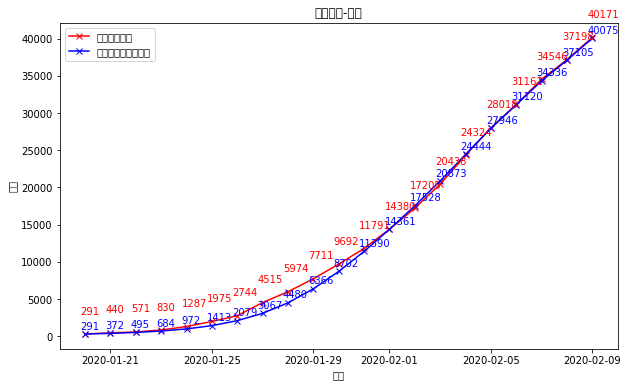

差分序列次数为： 2
0 0
0 1
1 0


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 1
BIC最小的p值和q值为：1、0
-0.012209780116558697
差分序列次数为： 2
0 0
0 1


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0 2
1 0


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 1


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 2


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 0
2 1


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 2


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


BIC最小的p值和q值为：0、0
-0.0003202084876587969
差分序列次数为： 2
0 0
0 1
0 2


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 0
1 1


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 2


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 0
2 1


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 2


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30123 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24773 missi

BIC最小的p值和q值为：0、0
-0.00037388656283452555
{'beta': 0.07541153183200418, 'gamma_2': 0.015157766021571067, 'theta': 0.0007813486904893674}


C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 27979 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0, flags=flags)


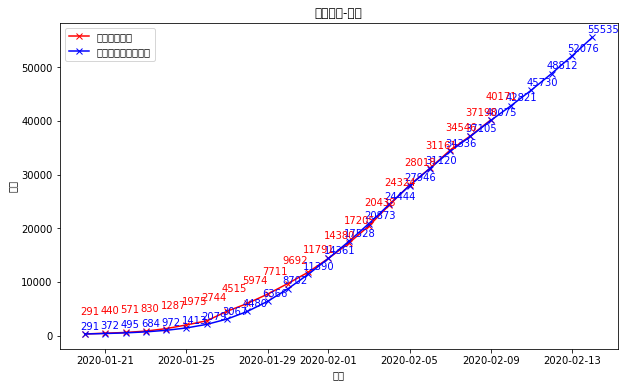

C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30123 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24773 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 29366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20917 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\85366\Anaconda3\envs\pytorch\lib\site-packages\matp

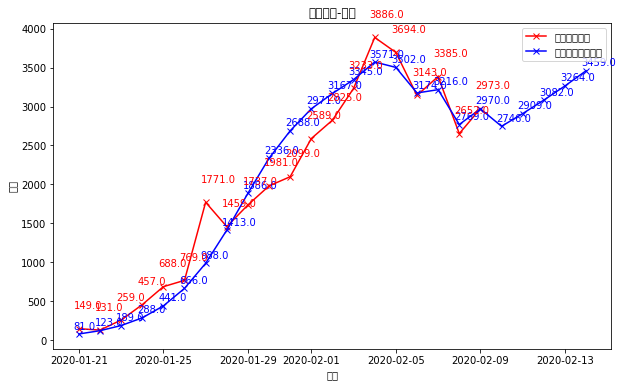

In [38]:
load_model_predict(model_city_date_path, data_china, city_name='全国')

In [29]:
h=[0.34293657018057455, 0.34356958663080606, 0.3445263953665961, 0.3458519761562857, 0.34740290648197797, 0.34875224440622654, 0.35007449584120415, 0.34508720833878614, 0.33534092132194987, 0.3193574121899007, 0.29708575814476124, 0.2736256698740591, 0.24611079652359738, 0.21919780464466446, 0.1942629488927123, 0.15853911003086013, 0.12673063199129236, 0.11688689690813935, 0.10066641344280985]
np.argmax(h)

6

In [ ]:
model_city_date_paths = ['models/shenzhen/02-08','models/wuhan/02-08','models/hubei/02-08','models/china/02-08']

In [ ]:
for model_i in range(len(model_city_date_paths)):
    print(model_city_date_paths[model_i]+':{')
    model_city_date_path = model_city_date_paths[model_i]
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    beta = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
    print(f'beta_model_{model_i}:{beta}')
    gamma_2 = []
    for i in range(len(model.SEIR_cells)):
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
    print(f'gamma_2_model_{model_i}:{gamma_2}')
    N = []
    for i in range(len(model.SEIR_cells)):
        N.append(model.SEIR_cells[i].N.detach().numpy()[0])
    print(f'N_model_{model_i}:{N}')    
    theta = []
    for i in range(len(model.SEIR_cells)):
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
    print(f'theta_model_{model_i}:{theta}')  
    print('}')

In [ ]:
len(model.SEIR_cells)

In [ ]:
beta_sz = []
for i in range(len(model.SEIR_cells)):
    beta_sz.append(model.SEIR_cells[i].beta.detach().numpy()[0])
beta_sz

In [69]:
def load_model_predict(model_city_date_path, data, N_cur=-1,beta=1e7,gamma_2=1e7,theta=1e7, city_name='深圳',c='confirmed', features=['I','cured','dead'], pred_date_len=5):
    global data_dict
    temp=[]
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    confirm_origin = get_data_acc_confirm(data,c=c)
    print(city_name)
#     print(confirm_origin)
#     plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name)
    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)
    
    beta = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
    gamma_2 = []
    for i in range(len(model.SEIR_cells)):
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
    theta = []
    for i in range(len(model.SEIR_cells)):
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
    param = model.param_pred(beta,gamma_2,theta)

#     print(param)
    S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(beta=param['beta'],gamma_2=param['gamma_2'],theta=param['theta'], pred_date_len = pred_date_len)
    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
#     temp.append(data['time'].values)
#     temp.append(confirm_origin)
    temp.append(confirm_pred)
#     temp.append(new_confirm)
   
    print(confirm_pred)
#     plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)
#     print(new_confirm)
    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    temp.append(new_confirm_pred_total)
    data_dict[city_name]=temp
#     print(new_confirm_pred_total)
#     plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)

In [70]:
import warnings
warnings.filterwarnings("ignore")
data_dict={}
citys=['湖北','武汉','全国']
paths=['./ncov/data/hubei_截至'+time+'_24时.csv','./ncov/data/wuhan_截至'+time+'_24时.csv','./ncov/data/nation_截至'+time+'_24时.csv']
modelpath=['./models/hubei/02-11','./models/wuhan/02-11','./models/china/02-11']
for i in range(3):
    data=read_data(paths[i])
#     print(data)
    city_name=citys[i]
    # N=0
    # if i == 3:
    #     N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
    # else :
    #     N = N_inits[i]
    # model_city_date_path = train_with_city_data(data,N,datetime,city_name)
    load_model_predict(modelpath[i], data, city_name=city_name)


湖北
[  270   337   433   569   759  1027  1405  1933  2670  3667  4974  6618
  8626 10995 13682 16669 19685 22391 24974 27225 29584 31776 33877 36082
 38396 40824 43372]
武汉
[  258   318   398   499   628   794  1006  1279  1630  2070  2614  3287
  4127  5173  6476  8096  9921 11712 13541 15111 16856 18436 19935 21547
 23282 25147 27152]
全国
[  291   371   491   672   943  1353  1965  2869  4174  5958  8243 10972
 14064 17426 20981 24679 28225 31391 34471 37222 40105 42721 44945 47231
 49580 51991 54470]


In [91]:
def get_recent_curve(data):
    index=0
    for i in range(len(data)):
        if i== 0 or i==len(data)-1:
            print('out')
            continue
        print(i)
        cur=data[i]
        left=data[i-1]
        right=data[i+1]
        if cur>left and cur>right:
            index=i
    return data[index:]    

In [92]:
test=[  60.,   80.,  101.,  129.,  166.,  212.,  273.,  351.,  440.,
          544.,  673.,  840., 1046., 1303., 1620., 1825., 1791., 1829.,
         1570., 1745., 1580., 1499., 1612., 1735., 1865., 2005.]
rec=get_recent_curve(test)

out
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
out


In [93]:
rec

[1745.0, 1580.0, 1499.0, 1612.0, 1735.0, 1865.0, 2005.0]